### 导入各种库

In [1]:
'''Trains a simple convnet on the MNIST dataset.

Gets to 99.25% test accuracy after 12 epochs
(there is still a lot of margin for parameter tuning).
16 seconds per epoch on a GRID K520 GPU.
'''
from __future__ import print_function
import keras
from keras.datasets import mnist
# 使用Sequential模型
from keras.models import Sequential
# 导入Dense，Dropout，Flatten，Conv2D，MaxPooling2D层
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
# 调用后端接口
from keras import backend as K

Using TensorFlow backend.


### 定义超参数

In [2]:
# batch大小，每处理128个样本进行一次梯度更新
batch_size = 128
# 类别数
num_classes = 10
# 迭代次数
epochs = 12

# input image dimensions
# 28x28 图像
img_rows, img_cols = 28, 28

### 准备数据

In [3]:
# the data, shuffled and split between train and test sets
(x_train, y_train), (x_test, y_test) = mnist.load_data()
# -x_train.shape:(6000, 28, 28)
# -x_test.shape:(1000, 28, 28)


# tf或th为后端，采取不同参数顺序，th为channels_first，tf为channels_last
if K.image_data_format() == 'channels_first':
    # -x_train.shape[0]=6000
    x_train = x_train.reshape(x_train.shape[0], 1, img_rows, img_cols)
    # -x_train.shape:(60000, 1, 28, 28)
    x_test = x_test.reshape(x_test.shape[0], 1, img_rows, img_cols)
    # x_test.shape:(10000, 1, 28, 28)
    # 单通道灰度图像,channel=1
    input_shape = (1, img_rows, img_cols)
else:
    x_train = x_train.reshape(x_train.shape[0], img_rows, img_cols, 1)
    x_test = x_test.reshape(x_test.shape[0], img_rows, img_cols, 1)
    input_shape = (img_rows, img_cols, 1)


# 数据转为float32型
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
# 归一化
x_train /= 255
x_test /= 255
print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

# convert class vectors to binary class matrices
# 标签转换为独热码
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

x_train shape: (60000, 28, 28, 1)
60000 train samples
10000 test samples


### 构建模型&训练&测试

In [4]:
# 构建模型
model = Sequential()
# 第一层为二维卷积层
# 32 为filters卷积核的数目，也为输出的维度
# kernel_size 卷积核的大小，3x3
# 激活函数选为relu 
# 第一层必须包含输入数据规模input_shape这一参数，后续层不必包含
model.add(Conv2D(32, kernel_size=(3, 3),
                 activation='relu',
                 input_shape=input_shape))
# 再加一层卷积，64个卷积核
model.add(Conv2D(64, (3, 3), activation='relu'))
# 加最大值池化
model.add(MaxPooling2D(pool_size=(2, 2)))
# 加Dropout，断开神经元比例为25%
model.add(Dropout(0.25))
# 加Flatten，数据一维化
model.add(Flatten())
# 加Dense，输出128维
model.add(Dense(128, activation='relu'))
# 再一次Dropout
model.add(Dropout(0.5))
# 最后一层为Softmax，输出为10个分类的概率
model.add(Dense(num_classes, activation='softmax'))

# 配置模型，损失函数采用交叉熵，优化采用Adadelta，将识别准确率作为模型评估
model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.Adadelta(),
              metrics=['accuracy'])

# 训练模型，载入数据，verbose=1为输出进度条记录
# validation_data为验证集
model.fit(x_train, y_train,
          batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_data=(x_test, y_test))

# 开始评估模型效果
# verbose=0为不输出日志信息
score = model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Train on 60000 samples, validate on 10000 samples
Epoch 1/12
60000/60000 [==============================] - 7s 115us/step - loss: 0.2619 - acc: 0.9192 - val_loss: 0.0545 - val_acc: 0.9824
Epoch 2/12
60000/60000 [==============================] - 5s 76us/step - loss: 0.0843 - acc: 0.9749 - val_loss: 0.0393 - val_acc: 0.9866
Epoch 3/12
60000/60000 [==============================] - 4s 71us/step - loss: 0.0641 - acc: 0.9811 - val_loss: 0.0354 - val_acc: 0.9875
Epoch 4/12
60000/60000 [==============================] - 4s 71us/step - loss: 0.0521 - acc: 0.9845 - val_loss: 0.0323 - val_acc: 0.9889
Epoch 5/12
60000/60000 [==============================] - 4s 70us/step - loss: 0.0472 - acc: 0.9853 - val_loss: 0.0299 - val_acc: 0.9900
Epoch 6/12
60000/60000 [==============================] - 4s 69us/step - loss: 0.0403 - acc: 0.9876 - val_loss: 0.0307 - val_acc: 0.9886
Epoch 7/12
60000/60000 [==============================] - 4s 69us/step - loss: 0.0359 - acc: 0.9891 - val_loss: 0.0309 - val_ac

### 使用回调&Tensorboard

On_train_begin
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 26, 26, 32)        320       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 24, 24, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 12, 12, 64)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 12, 12, 64)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 9216)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               1179776   
_________________________________________________________________
dropout_2 (Dropout)          (None, 128)               0     

No handles with labels found to put in legend.


0 0.012918707954627462 <class 'int'> <class 'numpy.float64'>


No handles with labels found to put in legend.


1 0.010722494002885651 <class 'int'> <class 'numpy.float64'>


No handles with labels found to put in legend.


2 0.01059785547707385 <class 'int'> <class 'numpy.float64'>


No handles with labels found to put in legend.


3 0.01130450480185294 <class 'int'> <class 'numpy.float64'>


No handles with labels found to put in legend.


4 0.011568312422989401 <class 'int'> <class 'numpy.float64'>


No handles with labels found to put in legend.


5 0.011868538031716403 <class 'int'> <class 'numpy.float64'>


No handles with labels found to put in legend.


6 0.010977633775103217 <class 'int'> <class 'numpy.float64'>


No handles with labels found to put in legend.


7 0.010583850064691312 <class 'int'> <class 'numpy.float64'>


No handles with labels found to put in legend.


8 0.009643727036183311 <class 'int'> <class 'numpy.float64'>


No handles with labels found to put in legend.


9 0.01022935587244574 <class 'int'> <class 'numpy.float64'>


No handles with labels found to put in legend.


10 0.010255988154917335 <class 'int'> <class 'numpy.float64'>


No handles with labels found to put in legend.


11 0.01058265076095704 <class 'int'> <class 'numpy.float64'>
Test loss: 0.038384983515358725
Test accuracy: 0.9915


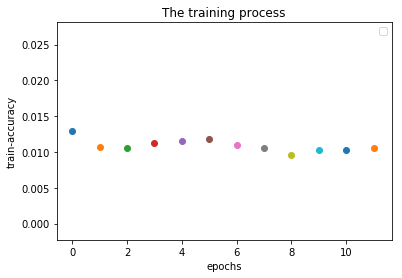

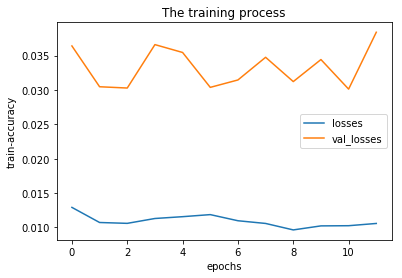

In [16]:
from keras.callbacks import EarlyStopping
from keras.callbacks import LambdaCallback
import matplotlib.pyplot as plt
import numpy as np


# callback on_train_run as a Class
class Mylogger(keras.callbacks.Callback):
    def on_train_begin(self,logs=None):
        print('On_train_begin')
        # model.summary()
        print(keras.utils.layer_utils.print_summary(self.model))

# callback loss-show
show_loss_callback = LambdaCallback(on_epoch_end = lambda epoch,logs:
    print(epoch,logs['loss'],type(epoch),type(logs['loss'])))

# callback loss-plot
def vis(e,l):
    plt.figure(1)
    plt.scatter(e,l)
    plt.xlabel('epochs')
    plt.ylabel('train-accuracy')
    plt.legend()
    plt.title('The training process')

plot_loss_callback = LambdaCallback(on_epoch_end = lambda epoch,logs:
    vis(epoch,logs['loss']))

# recording loss history
class LossHistory(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.losses = []
        self.val_losses = []

    def on_epoch_end(self, epoch, logs={}):
        self.losses.append(logs['loss'])
        self.val_losses.append(logs['val_loss'])
    def vis_losss(self):
        plt.figure(2)
        plt.plot(np.arange(len(self.losses)),self.losses,label='losses')
        plt.plot(np.arange(len(self.val_losses)),self.val_losses,label='val_losses')
        plt.xlabel('epochs')
        plt.ylabel('train-accuracy')
        plt.legend()
        plt.title('The training process')
#%%
history = LossHistory()

# callback tensorboard           
tbCallBack = keras.callbacks.TensorBoard(log_dir='./Graph')
#                                          histogram_freq=0, 
#                                          write_graph=True, 
#                                          write_images=True)

#%%
patience = 4

model_history = model.fit(x_train, 
                    y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=0,
                    validation_data=(x_test, y_test),
                    callbacks = [Mylogger(),
                                 tbCallBack,
#                                  EarlyStopping(patience=patience,mode='min',verbose=0),
                                 show_loss_callback,
                                 plot_loss_callback,
                                 history])

score = model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])
history.vis_losss()

In [ ]:
from keras.utils import plot_model
plot_model(model, to_file='model.png')